## Visualizing Results of TemporalMapper

In [1]:
import temporalmapper as tm
import temporalmapper.utilities_ as tmutils
import temporalmapper.weighted_clustering as tmwc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, io
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
import datamapplot as dmp

In [2]:
map_data = np.load('../data/ai_arxiv_coordinates.npy')
df = pd.read_feather('../data/ai_arxiv_data.feather')
print(map_data.shape)
df.head()

(10000, 2)


,title,abstract,id,created,authors,arxiv,doi
0,automated rating of recorded classroom present...,effective presentation skills can help to succ...,1801.00453,2018-01-01,"[akzharkyn izbassarova, aidana irmanova, a. p....",cs.ai,10.1109/icacci.2017.8125872
1,accelerating deep learning with memcomputing,restricted boltzmann machines (rbms) and their...,1801.00512,2018-01-01,"[haik manukian, fabio l. traversa, massimilian...",cs.ai,
2,accelerating deep learning with memcomputing,restricted boltzmann machines (rbms) and their...,1801.00512,2018-01-01,"[haik manukian, fabio l. traversa, massimilian...",cs.lg,
3,accurate reconstruction of image stimuli from ...,"in neuroscience, all kinds of computation mode...",1801.00602,2018-01-02,"[kai qiao, chi zhang, linyuan wang, bin yan, j...",cs.ai,
4,deep learning: a critical appraisal,although deep learning has historical roots go...,1801.00631,2018-01-02,[gary marcus],cs.lg,


In [3]:
# Compute a time column T which is the number of days since Jan 01, 2018.
def date_to_T(date):
    d0 = pd.Timestamp('2018-01-01')
    delta = date-d0
    return delta.days

df["date"] = pd.to_datetime(df["created"])
df["T"] = df["date"].apply(
    lambda x: date_to_T(x)
)
time = df["T"].to_numpy()

In [28]:
clusterer = HDBSCAN(cluster_selection_method='leaf')
TM = tm.TemporalMapper(
    time,
    map_data,
    clusterer,
    N_checkpoints = 14,
    kernel=tmwc.square
)
TM.fit()

### Time Semantic Plot

A *time-semantic-plot* is named for its axes; with time on the $x$-axis and one semantic component on the $y$-axis, this plot sacrifices clarity in semantic distance to explicitly plot the graph with a time axis.

Compute any 1D reduction of your data, and then call `temporalmapper.utilities.time_semantic_plot`, with the `TemporalMapper` object and your reduction as arguments:

<Axes: >

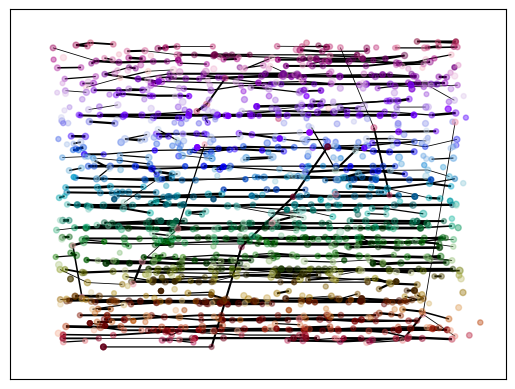

In [69]:
angle = np.arctan2(map_data[:,1], map_data[:,0]) 
tmutils.time_semantic_plot(TM, angle)

The optional `ax` argument allows you to pass a pre-made matplotlib axis, allowing you to add additional information to the plot as you wish.

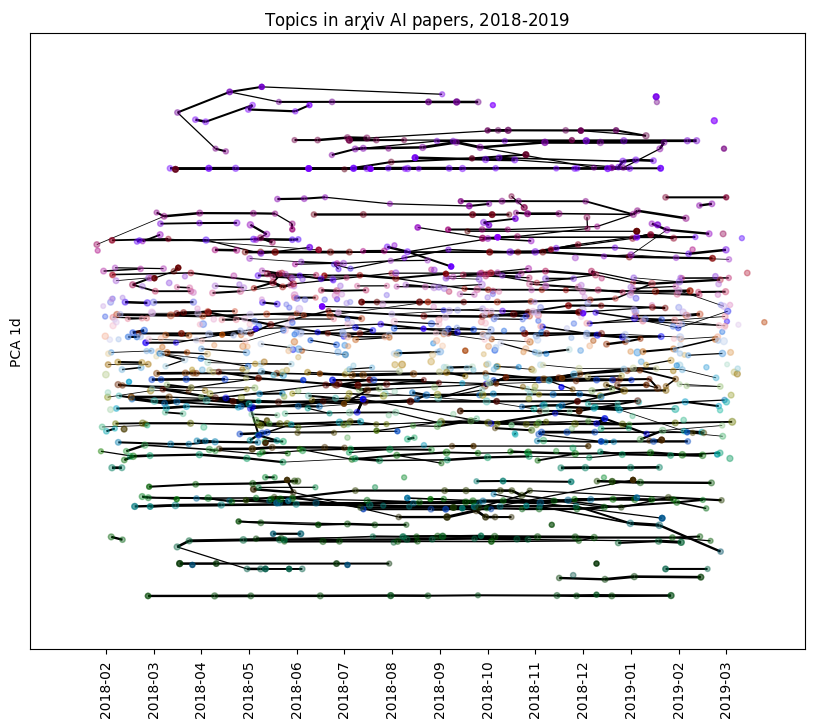

In [70]:
from sklearn.decomposition import PCA
from datetime import datetime, timedelta

y_axis =  PCA(n_components=1).fit_transform(TM.data)

fig, ax = plt.subplots(1,1)
tmutils.time_semantic_plot(TM, y_axis, ax=ax)
label_times = TM.checkpoints
label_dates = [
    (pd.Timestamp('2018-01-01')+timedelta(days=int(x))).strftime('%Y-%m')
     for x in label_times
]
ax.set_xticks(label_times,labels=label_dates)
ax.tick_params(axis='x', labelrotation=90)
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title("Topics in ar$\chi$iv AI papers, 2018-2019")
ax.set_ylabel("PCA 1d")
ax.tick_params(bottom=True, labelbottom=True)
plt.show()

For any appreciably complex dataset, the Mapper graph will be hard to interpret when it is plotted in its entirely. To plot the subgraph spanned by a list of vertices, `s`, you can pass the list to `time_semantic_plot` with `vertices=s`.

For example, `TemporalMapper.vertex_subgraph(node)` will return the subgraph spanned by all the ancestors and descendants of `node`.

In [68]:
TM.vertex_subgraph('3:12')

array(['10:24', '10:25', '11:15', '11:16', '12:15', '12:16', '13:16',
       '1:10', '2:20', '3:12', '4:16', '4:17', '5:8', '5:9', '6:13',
       '6:14', '7:6', '7:7', '8:5', '9:19', '9:20'], dtype='<U5')

We can pass this to the plotting function to see just this subgraph.

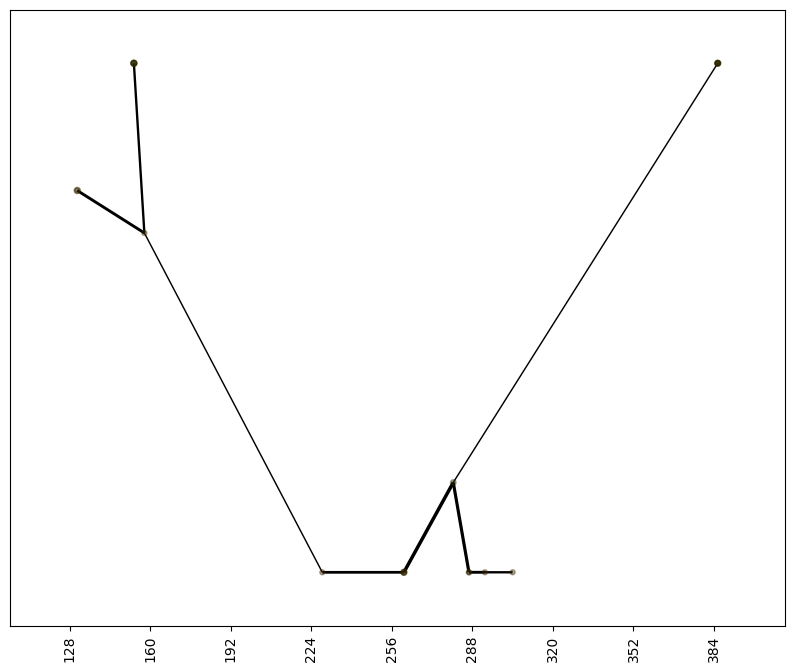

In [71]:
from sklearn.decomposition import PCA
from datetime import datetime, timedelta

y_axis =  PCA(n_components=1).fit_transform(TM.data)

fig, ax = plt.subplots(1,1)


tmutils.time_semantic_plot(
    TM,
    y_axis,
    ax=ax,
    vertices = TM.vertex_subgraph('3:12')
)

ax.tick_params(bottom=True, labelbottom=True)
fig.set_figwidth(10)
fig.set_figheight(8)
plt.show()

The `time_semantic_plot` uses `networkx`'s plotting functions, `draw_networkx_nodes` and `draw_networkx_edges`. If you want to further customize the look of the plot, you can pass dictionaries `node_kwargs` and `edge_kwargs` that will be passed along to these functions.

### Centroid Datamap
todo complete this documentation